### Pegando pontos de interesse da mascara

In [13]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

In [4]:
def listar_imagens(diretorio_raiz, extensoes_imagens=None):
    if extensoes_imagens is None:
        extensoes_imagens = ['.jpg', '.jpeg', '.png']

    arquivos_imagens = []
    for dirpath, _, filenames in os.walk(diretorio_raiz):
        for filename in filenames:
            if any(filename.lower().endswith(extensao) for extensao in extensoes_imagens):
                caminho_completo = os.path.join(dirpath, filename)
                arquivos_imagens.append(caminho_completo)
    return arquivos_imagens
  
def exibir_imagens(lista_de_caminhos, largura=40, altura=25, path=True):
    num_imagens = len(lista_de_caminhos)
    
    if path:
    
      fig, axes = plt.subplots(1, num_imagens, figsize=(largura, altura))
    
      for i, caminho in enumerate(lista_de_caminhos):

          imagem = Image.open(caminho)
            
          axes[i].imshow(imagem)
          axes[i].axis('off')
          img = caminho.split("/")
          img = img[len(img)-1].replace("\\", " ").replace(".png", "")
          if "for" in img:
            img = img.replace("for intraepithelial lesion", "")
          axes[i].set_title(img)
      plt.show()
    else:
      
      fig, axes = plt.subplots(nrows=len(lista_de_caminhos), ncols=3, figsize=(largura, altura))
      plt.subplots_adjust(wspace=0.2)
      
      for i, each in enumerate(lista_de_caminhos):

          
          
          axes[i, 1].imshow(each["img-seg"])
          axes[i, 1].axis('off')
          if "for" in each["title"]:
            axes[i, 1].set_title(f'Segmentada  - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 1].set_title(f'Segmentada  - {each["title"]}')
              
          
          axes[i, 0].imshow(each["img"])
          axes[i, 0].axis('off')
          
          if "for" in each["title"]:
            
            axes[i, 0].set_title(f'Original - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 0].set_title(f'Original - {each["title"]}')
          
          axes[i, 2].imshow(each["img-mask"])
          axes[i, 2].axis('off')
          if "for" in each["title"]:
            axes[i, 2].set_title(f'Mask - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 2].set_title(f'Mask - {each["title"]}')
            
      plt.show()

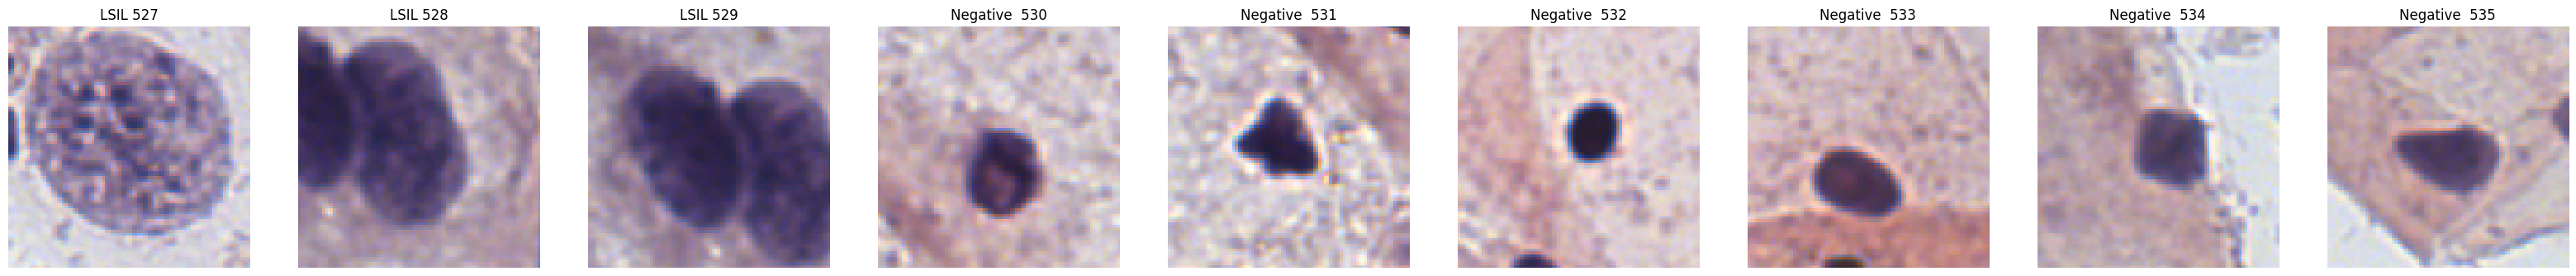

In [6]:
directory_path = '../../data/base_recortada/'
images = listar_imagens(directory_path)
exibir_imagens(images)

### Segmentação com Grabcut

In [12]:
def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada

In [20]:
def plot(resultados):
  num_cols = 3
  num_images = len(resultados)
  num_rows = (num_images + num_cols - 1) // num_cols 

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

  for i, img in enumerate(resultados):
      row = i // num_cols
      col = i % num_cols
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[row, col].imshow(img_rgb)
      axes[row, col].axis('off') 

  for j in range(num_images, num_rows * num_cols):
      fig.delaxes(axes.flat[j])

  plt.tight_layout()
  plt.show()

In [15]:
imagens_path = listar_imagens("../../data/base_recortada/")

lista_resultado = []

for path_img in imagens_path:
  imagem = cv2.imread(path_img)
  img_recortada, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem=imagem)
  lista_resultado.append(img_recortada)
  lista_resultado.append(mask)
  lista_resultado.append(img_original_recortada)
  


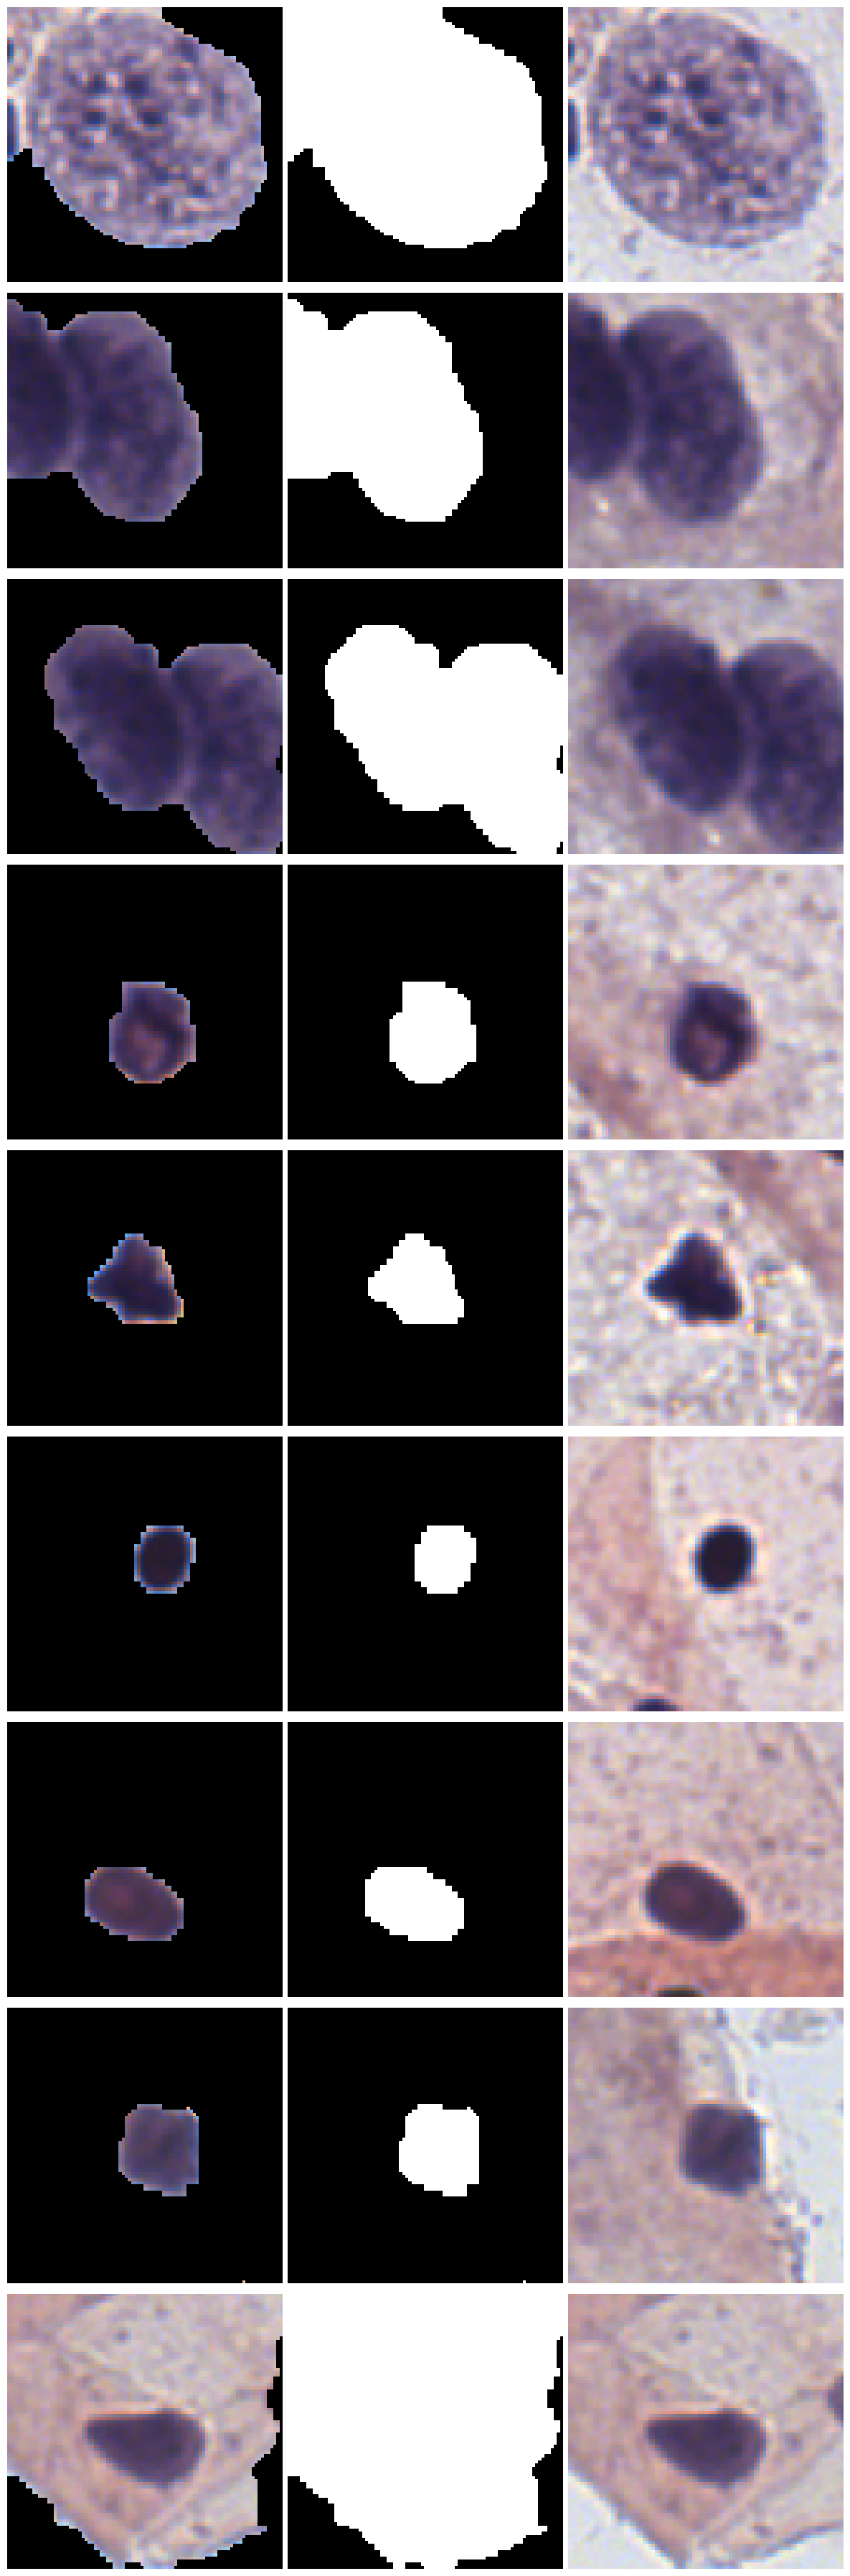

In [22]:
plot(lista_resultado)

### Definir Patches da areas de interesse